## Split slice grappa with in plane acceleration
###### Author: Zimu Huo
###### Date: 05.2022

The slice grappa tries to reduce the total artefact without placing constraints on the intraslice and interslice artifacts. So the artefacts can be arbitrarily large(like vectors pointing in opposite directions can cancel out each other, also called artefact cancellation). The split slice trades interslice artefact with intraslice artefact (lower interslice artefact and higher intraslice artefact) by forming a "correlation matrix" that contrains the interslice leakage to be minimum. 

-------------------------------------------------------------------------
References

    [1] 
    Author:  Stephen F. Cauley et al. 
    Title: Interslice leakage artifact reduction technique for simultaneous multislice acquisitions
    Link: https://pubmed.ncbi.nlm.nih.gov/23963964/

In [2]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import util.simulator as simulate
from util.coil import *
from util.fft import *
import util.mask as undersample
from util.spsg import *

In [3]:
numSlice = 4
R = 4
from util.twix import *
file_sms = "../lib/meas_MID00134_FID55501_catesain_4slices.dat"
file = readtwix(file_sms)
data = file[0]['readouts'][...,:numSlice]
rawImage = ifft2c(data)
fovHeight, fovWidth, numCoil, _ = rawImage.shape
fovHeight, fovWidth, numCoil, _ = rawImage.shape

Software version: VD/VE (!?)

Scan  0
100 % parsed in 1 s. Estimated 0 s remaining.
Scan  1
100 % parsed in 2 s. Estimated 0 s remaining.
----------------------------------------------------------------------------------------------------
reading raw data, calculating trajectories and sampling raster 


  0%|          | 0/1063 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
file parsed, the scans detected in sequential order are: 
DATA
DATA
DATA
DATA
----------------------------------------------------------------------------------------------------
loading and preprocessing the data..
[' sli: 0 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 1 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 2 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 3 par: 0 rep: 0 phs: 0 dtype: DATA']
 sli: 0 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 1 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 2 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 3 par: 0 rep: 0 phs: 0 dtype: DATA
----------------------------------------------------------------------------------------------------
dynamically combining data according to dtype, sli, par, rep..
concat  DATA DATA 3
concat  DATA DATA 3
concat  DATA DATA 3
----------------------------------------------------------------------------------------------------
finished, the 

In [4]:
rawData = np.zeros(rawImage.shape, dtype = complex)
for sli in range (numSlice):
        rawData[:,:,:,sli] = fft2c(rawImage[:,:,:,sli])

In [5]:
cycle = np.arange(0,1,1/numSlice) * 2* np.pi
numAccq = int(numSlice*fovHeight/R)

In [6]:
shift = cycle*numAccq/(2*np.pi)
dataR = fft2c(simulate.multiSliceCAIPI(rawImage, cycle, R))

In [7]:
ncx = 32
ncy = 32
acsshift = cycle*int(numSlice* ncy /R)/(2*np.pi)
acsK = simulate.acs(rawData, (ncy, ncx))
acsIm = ifft2c(acsK)
calib = fft2c(simulate.singleSliceFov(acsIm,acsshift))

patch taken from 112 : 144 in y
patch taken from 112 : 144 in x


In [9]:
recon = spsg(dataR, calib)

  0%|          | 0/4 [00:00<?, ?it/s]

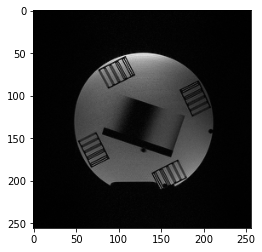

In [10]:
show(rsos(ifft2c(recon[:,:,:,0])))